In [1]:
import numpy as np
import time
import multiprocessing
import random 
from jax import random as jrandom
import jax.numpy as jnp
import jax
from scipy.optimize import fsolve
from jax import jit, partial, grad, jacfwd

import matplotlib.pyplot as plt
from tqdm import tqdm 

%matplotlib inline
plt.rcParams['figure.figsize'] = [16,8]
plt.style.use('ggplot')
plt.rcParams['lines.markersize'] = 8


In [2]:
def jax_hit_run(x_0, F, dim, N, R, alpha, new_jrandom_key, chosen_basis_idx=None):
    new_jrandom_key, subkey = jrandom.split(new_jrandom_key)
    # sample gaussian and normalize 
    if chosen_basis_idx is None:
        dirs = jrandom.normal(subkey, shape=(N, dim)) 
    else:
        dirs = jrandom.normal(subkey, shape=(N, len(chosen_basis_idx)))
        temp_dirs = jnp.zeros((dim, N))
        temp_dirs = jax.ops.index_update(temp_dirs, chosen_basis_idx, dirs.T)
        dirs = temp_dirs.T

    dirs = dirs/jnp.linalg.norm(dirs, axis=1).reshape(-1, 1)

    new_jrandom_key, subkey = jrandom.split(new_jrandom_key)
    beta_p = (jrandom.beta(subkey, alpha, alpha, shape=(N, 1)) - 0.5) * 2 * R 

    res = []
    res += dirs * beta_p
    return x_0 + jnp.array(res)

def beta_2E1(F, x_0, alpha, N, R, jrandom_key, control_variate=True):
    jrandom_key, subkey = jrandom.split(jrandom_key)
    sample_points = jax_hit_run(x_0, F, x_0.shape[0], N, R, alpha, subkey)  
    if control_variate: 
        ru = sample_points - jnp.mean(sample_points, axis=0)
    else:
        ru = sample_points - x_0
    jrandom_key, subkey = jrandom.split(jrandom_key)
    out_grads = F.f1(sample_points, subkey)
    g_ru = out_grads.T.dot(ru)/float(N)
    cov =  jnp.cov(sample_points.T).reshape(x_0.shape[0], x_0.shape[0]) # beta_covariance(x_0.shape[0], R, alpha) #
    return g_ru.dot(jnp.linalg.inv(cov))

def gauss_2E1(F, x_0, var, N, jrandom_key, control_variate=True):
    jrandom_key, subkey = jrandom.split(jrandom_key)
    sample_points = x_0 + jnp.sqrt(var)*jrandom.normal(subkey, shape=(N, dim))  
    if control_variate: 
        ru = sample_points - jnp.mean(sample_points, axis=0)
    else:
        ru = sample_points - x_0
    jrandom_key, subkey = jrandom.split(jrandom_key)
    out_grads = F.f1(sample_points, subkey)
    g_ru = out_grads.T.dot(ru)/float(N)
    cov =  jnp.cov(sample_points.T).reshape(x_0.shape[0], x_0.shape[0]) # beta_covariance(x_0.shape[0], R, alpha) #
    return g_ru.dot(jnp.linalg.inv(cov))

def laplace_2E1(F, x_0, b, N, jrandom_key, control_variate=True):
    jrandom_key, subkey = jrandom.split(jrandom_key)
    sample_points = x_0 + b*jrandom.laplace(subkey, shape=(N, dim))  
    if control_variate: 
        ru = sample_points - jnp.mean(sample_points, axis=0)
    else:
        ru = sample_points - x_0
    jrandom_key, subkey = jrandom.split(jrandom_key)
    out_grads = F.f1(sample_points, subkey)
    g_ru = out_grads.T.dot(ru)/float(N)
    cov =  jnp.cov(sample_points.T).reshape(x_0.shape[0], x_0.shape[0]) # beta_covariance(x_0.shape[0], R, alpha) #
    return g_ru.dot(jnp.linalg.inv(cov))

def logistic_2E1(F, x_0, b, N, jrandom_key, control_variate=True):
    jrandom_key, subkey = jrandom.split(jrandom_key)
    sample_points = x_0 + b*jrandom.logistic(subkey, shape=(N, dim))  
    if control_variate: 
        ru = sample_points - jnp.mean(sample_points, axis=0)
    else:
        ru = sample_points - x_0
    jrandom_key, subkey = jrandom.split(jrandom_key)
    out_grads = F.f1(sample_points, subkey)
    g_ru = out_grads.T.dot(ru)/float(N)
    cov =  jnp.cov(sample_points.T).reshape(x_0.shape[0], x_0.shape[0]) # beta_covariance(x_0.shape[0], R, alpha) #
    return g_ru.dot(jnp.linalg.inv(cov))

In [4]:
def FD_2FD1(F, x_0, h, num_samples, dim, jrandom_key):
    hess = []
    jrandom_key, subkey = jrandom.split(jrandom_key)
    nabla_f = F.f1(x_0.reshape(1, -1), subkey)[0]
    X = h*jnp.eye(dim) + x_0
    H = jnp.zeros(shape=(dim, dim))

    for _ in range(num_samples):
        jrandom_key, subkey = jrandom.split(jrandom_key)
        H = jax.ops.index_add(H, jax.ops.index[:, :], (F.f1(X, subkey) - nabla_f)/h)

    H = H / float(num_samples)
    return H


In [183]:

def best_width_search(f, upper_bound, lower_bound, num_samples, search_type="log"):
    
    if search_type == "log":
        search_space = jnp.logspace(jnp.log(lower_bound)/jnp.log(10), jnp.log(upper_bound)/jnp.log(10), num_samples)
    else:
        search_space = jnp.linspace(lower_bound, upper_bound, num_samples)
        
    f_vals = [f(x) for x in search_space]
    curr_best = float("inf")
    curr_h = 0
    for i in range(len(search_space)):
        if curr_best > f_vals[i]:
            curr_best = f_vals[i]
            curr_h = search_space[i]
            
    return curr_h, curr_best
    
    
    
    
def hessian_comp(true_H, approx_H_func, true_grad=None):
    if true_grad is not None:
        trueHg = jnp.linalg.inv(true_H).dot(true_grad)
        trueHg /= jnp.linalg.norm(trueHg)
    
    def helper(h):
        approx_H = approx_H_func(h)
        
        if true_grad is None:
            return jnp.mean(jnp.abs((approx_H - true_H)/true_H))
        
        
        # cosine similarity 
        approxHg = jnp.linalg.inv(approx_H).dot(true_grad)
        approxHg /= jnp.linalg.norm(approxHg)
        
        return 1 - approxHg.dot(trueHg)
        
#         return jnp.linalg.norm((true_H - approx_H)/true_H) #/ true_H.shape[1]**2 #jnp.linalg.norm(true_H)
    
    return helper

In [156]:
num_approx_samples = 2000



FD_upper_bound, FD_lower_bound = 0.2, 0.0001
B_upper_bound, B_lower_bound = 100, 1
G_upper_bound, G_lower_bound = 10, 0.0001
h_samples = 10

FD_R = 0.2

jrandom_key = jrandom.PRNGKey(0)

FD_res = []
B_res = []
G_res = []


for dim in range(50, 500, 50):
    print(dim)
    
    
    num_FD_samples = 20
    num_B_samples = 20 * dim
    
    x_0 =  jnp.ones(dim) / jnp.linalg.norm(jnp.ones(dim))
    Q = jnp.eye(dim)
    F = Quadratic(Q, jnp.zeros(dim))
    true_H = F.f2(x_0.reshape(1, -1))[0]
    
    beta_f = lambda h: beta_2E1(F, x_0, h, num_B_samples, FD_R, jrandom_key)
    gauss_f = lambda h: gauss_2E1(F, x_0, h, num_B_samples, jrandom_key)
    FD_f = lambda h: FD_2FD1(F, x_0, h, num_FD_samples, dim, jrandom_key)
    
    curr_B_val = best_width_search(hessian_comp(true_H, beta_f), B_upper_bound, B_lower_bound, h_samples, search_type="log")[1]
    curr_FD_val = best_width_search(hessian_comp(true_H, FD_f), FD_upper_bound, FD_lower_bound, h_samples, search_type="log")[1]
    curr_G_val = best_width_search(hessian_comp(true_H, gauss_f), G_upper_bound, G_lower_bound, h_samples, search_type="log")[1]
    
    B_res.append(curr_B_val)
    FD_res.append(curr_FD_val)
    G_res.append(curr_G_val)
    
    
    

50
100
150
200
250
300
350
400
450


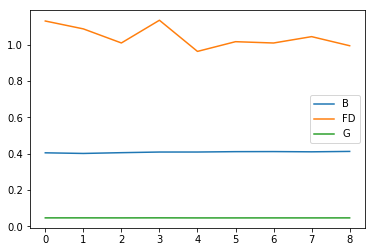

In [157]:
plt.plot(B_res, label="B")
plt.plot(FD_res, label="FD")
plt.plot(G_res, label="G")

# plt.yscale("log")
plt.legend()
plt.show()

In [6]:
class Quadratic:
    def __init__(self, Q, b):
        self.Q = Q
        self.Q_inv = jnp.linalg.inv(Q)
        self.b = b
        
    def f(self, X):
        Y = np.dot(self.Q, X.T)
        Y = jnp.diag(jnp.dot(X, Y)) + X.dot(self.b) # TODO fix. inefficient way to remove x_j^T Q x_i for i != j. 
        return Y
    
    def f1(self, X, jrandom_key=None):
        Y = 2*jnp.dot(self.Q, X.T)
        if jrandom_key is not None:
            return Y.T + self.b + 0.2 * jrandom.normal(jrandom_key, shape=Y.T.shape) * jnp.linalg.norm(Y.T, axis=1).reshape(-1, 1) / jnp.sqrt(X.shape[1]) 
        return Y.T + self.b

        
    def f2(self, X, jrandom_key=None):
        return 2 * np.array([list(self.Q)] * X.shape[0])

    def f2_inv(self, X):
        return 1/2. * np.array([list(self.Q_inv)] * X.shape[0])


In [175]:
class Brown:
    def __init__(self):
        pass
    
    def f(self, X):
        X2 = X**2
        return jnp.sum(X2[:, :-1]**(X2[:, 1:] + 1) + X2[:, 1:]**(X2[:, :-1] + 1), axis=1)
    
    def f1(self, X, jrandom_key=None):
        X2 = X**2 
        logX2 = jnp.log(X2)
        logX2 = jax.ops.index_update(logX2, X2 == 0, 0)
        grad = jnp.zeros(X.shape)
        middle_terms = (2*(X2[:, 2:] + 1))*X2[:, 1:-1]**(X2[:, 2:])*X[:, 1:-1] + 2 * X[:, 1:-1] * logX2[:, 2:] * X2[:, 2:]**(X2[:, 1:-1] + 1) \
                        + (2*(X2[:, :-2] + 1))*X2[:, 1:-1]**(X2[:, :-2])*X[:, 1:-1] + 2 * X[:, 1:-1] * logX2[:, :-2]  * X2[:, :-2]**(X2[:, 1:-1] + 1)
        zeroth_term = (2*(X2[:, 1] + 1))*X2[:, 0]**(X2[:, 1])*X[:, 0] + 2 * X[:, 0] * logX2[:, 1] * X2[:, 1]**(X2[:, 0] + 1) 
        last_term = (2*(X2[:, -2] + 1))*X2[:, -1]**(X2[:, -2])*X[:, -1] + 2 * X[:, -1] * logX2[:, -2]  * X2[:, -2]**(X2[:, -1] + 1)
        
        grad = jax.ops.index_update(grad, jax.ops.index[:, 1:-1], middle_terms)
        grad = jax.ops.index_update(grad, jax.ops.index[:, 0], zeroth_term)
        grad = jax.ops.index_update(grad, jax.ops.index[:, -1], last_term)

        
        if jrandom_key is not None:
            return grad + 0.5 * jrandom.normal(jrandom_key, X.shape) * jnp.linalg.norm(grad, axis=1).reshape(-1, 1) / jnp.sqrt(X.shape[1])
        
        return grad
    
    def f2(self, X):
        return jacfwd(lambda x: self.f1(x, None))(X).reshape(X.shape[0], X.shape[1], X.shape[1])
    
# B = Brown()
# dim = 5
# x_0 =  -1*jnp.ones(dim) / jnp.linalg.norm(jnp.ones(dim)).reshape(1, -1)
# print((B.f1(x_0)[0]))
# print(B.f1(x_0)[0].dot(jnp.ones(dim) / jnp.linalg.norm(jnp.ones(dim))))
# h = 0.0001
# I = jnp.eye(x_0.shape[1])
# (B.f(x_0 + h*jnp.ones(dim) / jnp.linalg.norm(jnp.ones(dim))) - B.f(x_0))/h


In [156]:
dim = 50
res = []
resFD = []
resFDH = []
res_f = []
x_upper_bound, x_lower_bound, x_samples = 3, -3, 10
B = Brown()
h = 0.001
for x in jnp.linspace(x_lower_bound, x_upper_bound, x_samples):
    x_0 =  x*jnp.ones(dim) / jnp.linalg.norm(jnp.ones(dim))
    res_f.append(B.f(x_0.reshape(1, -1)))
    res.append(B.f1(x_0.reshape(1, -1))[0].dot(jnp.ones(dim) / jnp.linalg.norm(jnp.ones(dim))))
#     resFD.append((B.f((x_0 + h*jnp.ones(dim) / jnp.linalg.norm(jnp.ones(dim))).reshape(1, -1)) - B.f(x_0.reshape(1, -1)))/h)
    resFDH.append((jnp.ones(dim) / jnp.linalg.norm(jnp.ones(dim))).dot(B.f2(x_0.reshape(1, -1))).dot(jnp.ones(dim) / jnp.linalg.norm(jnp.ones(dim))))
    

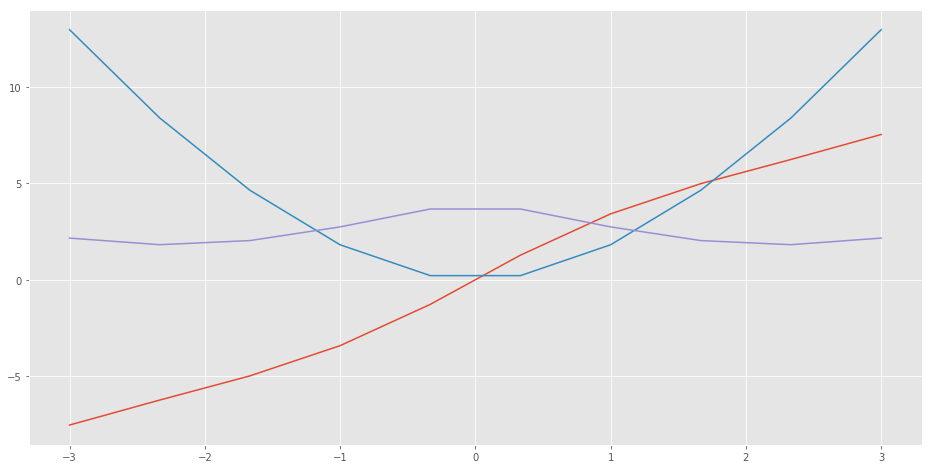

In [157]:
plt.plot(jnp.linspace(x_lower_bound, x_upper_bound, x_samples), res)
# plt.plot(jnp.linspace(x_lower_bound, x_upper_bound, x_samples), resFD)
plt.plot(jnp.linspace(x_lower_bound, x_upper_bound, x_samples), res_f)
plt.plot(jnp.linspace(x_lower_bound, x_upper_bound, x_samples), resFDH)


In [184]:
B = Brown()

# dim = 20
dim = 500
num_FD_samples = 10
num_B_samples = 10 * dim

jrandom_key = jrandom.PRNGKey(0)

FD_upper_bound, FD_lower_bound = 0.2, 1e-6
B_upper_bound, B_lower_bound = 100, 1
G_upper_bound, G_lower_bound = 1, 1e-4
L_upper_bound, L_lower_bound = 1, 1e-4
Log_upper_bound, Log_lower_bound = 1, 1e-4


h_samples = 20

FD_res = []
B_res = []
G_res = []
L_res = []
Log_res = []

x_upper_bound, x_lower_bound, x_samples = 3, -3, 10

for x in tqdm(jnp.linspace(x_lower_bound, x_upper_bound, x_samples)):
#     print("X", x)
    x_0 =  x*jnp.ones(dim) / jnp.linalg.norm(jnp.ones(dim))
    true_H = B.f2(x_0.reshape(1, -1))[0]
    true_grad = B.f1(x_0.reshape(1, -1))[0]


    beta_f = lambda h: beta_2E1(B, x_0, h, num_B_samples, 1, jrandom_key)
    FD_f = lambda h: FD_2FD1(B, x_0, h, num_FD_samples, dim, jrandom_key)
    gauss_f = lambda h: gauss_2E1(B, x_0, h, num_B_samples, jrandom_key)
    laplace_f = lambda h: laplace_2E1(B, x_0, h, num_B_samples, jrandom_key)
    logistic_f = lambda h: logistic_2E1(B, x_0, h, num_B_samples, jrandom_key)

#     FD_res.append(hessian_comp(true_H, FD_f, true_grad)(0.19999997))
#     G_res.append(hessian_comp(true_H, gauss_f, true_grad)(0.06320868))
    FD_res.append(best_width_search(hessian_comp(true_H, FD_f, true_grad), FD_upper_bound, FD_lower_bound, h_samples, search_type="log"))
#     B_res.append(best_width_search(hessian_comp(true_H, beta_f, true_grad), B_upper_bound, B_lower_bound, h_samples, search_type="log"))
    G_res.append(best_width_search(hessian_comp(true_H, gauss_f, true_grad), G_upper_bound, G_lower_bound, h_samples, search_type="log"))
#     L_res.append(best_width_search(hessian_comp(true_H, laplace_f, true_grad), L_upper_bound, L_lower_bound, h_samples, search_type="log"))
#     Log_res.append(best_width_search(hessian_comp(true_H, logistic_f, true_grad), Log_upper_bound, Log_lower_bound, h_samples, search_type="log"))

    
FD_res = jnp.array(FD_res)
B_res = jnp.array(B_res)
G_res = jnp.array(G_res)
L_res = jnp.array(L_res)
Log_res = jnp.array(Log_res)





  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:17<02:36, 17.41s/it]


 20%|██        | 2/10 [00:34<02:19, 17.41s/it]


 30%|███       | 3/10 [00:50<01:58, 16.90s/it]


 40%|████      | 4/10 [01:08<01:42, 17.09s/it]


 50%|█████     | 5/10 [01:25<01:26, 17.26s/it]


 60%|██████    | 6/10 [01:43<01:09, 17.49s/it]


 70%|███████   | 7/10 [01:59<00:51, 17.07s/it]


 80%|████████  | 8/10 [02:16<00:33, 16.83s/it]


 90%|█████████ | 9/10 [02:31<00:16, 16.48s/it]


100%|██████████| 10/10 [02:50<00:00, 17.04s/it]

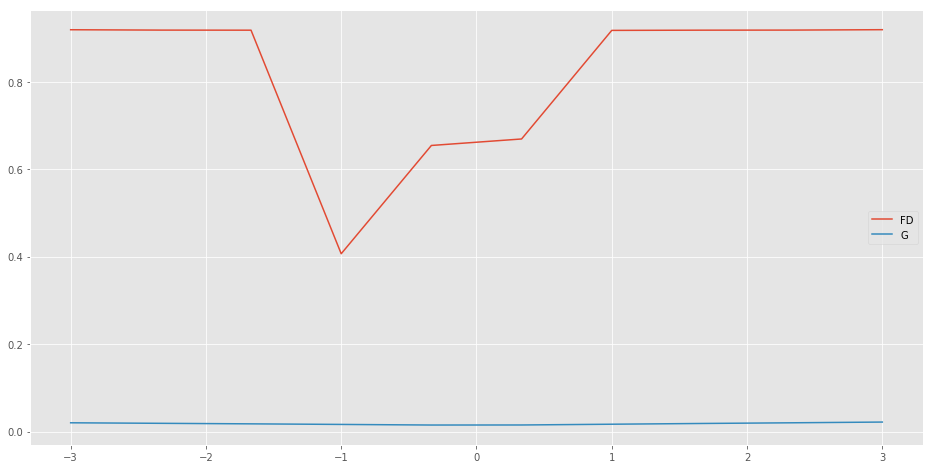

In [186]:
# plt.plot(jnp.linspace(x_lower_bound, x_upper_bound, x_samples), B_res[:, 1], label="B")
plt.plot(jnp.linspace(x_lower_bound, x_upper_bound, x_samples), FD_res[:, 1], label="FD")
plt.plot(jnp.linspace(x_lower_bound, x_upper_bound, x_samples), G_res[:, 1], label="G")
# plt.plot(jnp.linspace(x_lower_bound, x_upper_bound, x_samples), L_res[:, 1], label="L")
# plt.plot(jnp.linspace(x_lower_bound, x_upper_bound, x_samples), Log_res[:, 1], label="Log")


# plt.yscale("log")
plt.legend()

plt.show()

In [147]:
class Ackley:
    def __init__(self):
        pass
    
    def f(self, X):
        xs = X.T
        out_shape = xs[0].shape
        a = jnp.exp(-0.2 * jnp.sqrt(1. / len(xs) * jnp.square(jnp.linalg.norm(xs, axis=0))))
        b = - jnp.exp(1. / len(xs) *jnp.sum(jnp.cos(2 * jnp.pi * xs), axis=0))
        return jnp.array(-20 * a + b + 20 + jnp.exp(1)).reshape(out_shape)


    def f1(self, X, jrandom_key=None):
        """del H/del xi = -20 * -0.2 * (xi * 1/n) / sqrt(1/n sum_j xj^2) * a + 2 pi sin(2 pi xi)/n * b"""
        xs = X.T
        out_shape = xs.shape
        a = jnp.exp(-0.2 * jnp.sqrt(1. / len(xs) * jnp.square(jnp.linalg.norm(xs, axis=0))))
        b = -jnp.exp(1. / len(xs) * jnp.sum(jnp.cos(2 * jnp.pi * xs), axis=0))
        a_p = -0.2 * (xs * 1. / len(xs)) / jnp.sqrt(1. / len(xs) * jnp.square(jnp.linalg.norm(xs, axis=0)))
        b_p = -2 * jnp.pi * jnp.sin(2 * jnp.pi * xs) / len(xs)
        grad = jnp.nan_to_num(
            -20 * a_p * a + b_p * b).reshape(out_shape)  # only when norm(x) == 0 do we have nan and we know the grad is zero there
        grad = grad.T
        if jrandom_key is not None:
            return grad + 0.25 * jrandom.normal(jrandom_key, X.shape) * jnp.linalg.norm(grad, axis=1).reshape(-1, 1) / jnp.sqrt(X.shape[1])
        return grad

    def f2(self, X):
        return jacfwd(lambda x: self.f1(x, None))(X).reshape(X.shape[0], X.shape[1], X.shape[1])
                

In [188]:
A = Ackley()

# dim = 20
dim = 50
num_FD_samples = 10
num_B_samples = 10 * dim

jrandom_key = jrandom.PRNGKey(0)

FD_upper_bound, FD_lower_bound = 0.2, 1e-6
B_upper_bound, B_lower_bound = 1000, 1
G_upper_bound, G_lower_bound = 2, 1e-4
L_upper_bound, L_lower_bound = 2, 1e-4
Log_upper_bound, Log_lower_bound = 2, 1e-4


h_samples = 20

FD_res = []
B_res = []
G_res = []
L_res = []
Log_res = []

x_upper_bound, x_lower_bound, x_samples = 1, -1, 10

for x in tqdm(jnp.linspace(x_lower_bound, x_upper_bound, x_samples)):
#     print("X", x)
    x_0 =  x*jnp.ones(dim) / jnp.linalg.norm(jnp.ones(dim))
    true_H = A.f2(x_0.reshape(1, -1))[0]
    true_grad = A.f1(x_0.reshape(1, -1))[0]

    beta_f = lambda h: beta_2E1(A, x_0, h, num_B_samples, 1, jrandom_key)
    FD_f = lambda h: FD_2FD1(A, x_0, h, num_FD_samples, dim, jrandom_key)
    gauss_f = lambda h: gauss_2E1(A, x_0, h, num_B_samples, jrandom_key)
    laplace_f = lambda h: laplace_2E1(A, x_0, h, num_B_samples, jrandom_key)
    logistic_f = lambda h: logistic_2E1(A, x_0, h, num_B_samples, jrandom_key)


    FD_res.append(best_width_search(hessian_comp(true_H, FD_f, true_grad), FD_upper_bound, FD_lower_bound, h_samples, search_type="log"))
    B_res.append(best_width_search(hessian_comp(true_H, beta_f, true_grad), B_upper_bound, B_lower_bound, h_samples, search_type="log"))
    G_res.append(best_width_search(hessian_comp(true_H, gauss_f, true_grad), G_upper_bound, G_lower_bound, h_samples, search_type="log"))
    L_res.append(best_width_search(hessian_comp(true_H, laplace_f, true_grad), L_upper_bound, L_lower_bound, h_samples, search_type="log"))
    Log_res.append(best_width_search(hessian_comp(true_H, logistic_f, true_grad), Log_upper_bound, Log_lower_bound, h_samples, search_type="log"))

    
FD_res = jnp.array(FD_res)
B_res = jnp.array(B_res)
G_res = jnp.array(G_res)
L_res = jnp.array(L_res)
Log_res = jnp.array(Log_res)





  0%|          | 0/10 [00:00<?, ?it/s]



 10%|█         | 1/10 [00:04<00:39,  4.38s/it]



 20%|██        | 2/10 [00:09<00:36,  4.59s/it]



 30%|███       | 3/10 [00:13<00:31,  4.51s/it]



 40%|████      | 4/10 [00:18<00:26,  4.45s/it]



 50%|█████     | 5/10 [00:22<00:22,  4.44s/it]



 60%|██████    | 6/10 [00:26<00:17,  4.39s/it]



 70%|███████   | 7/10 [00:31<00:13,  4.56s/it]



 80%|████████  | 8/10 [00:36<00:09,  4.62s/it]



 90%|█████████ | 9/10 [00:41<00:04,  4.67s/it]



100%|██████████| 10/10 [00:45<00:00,  4.65s/it]

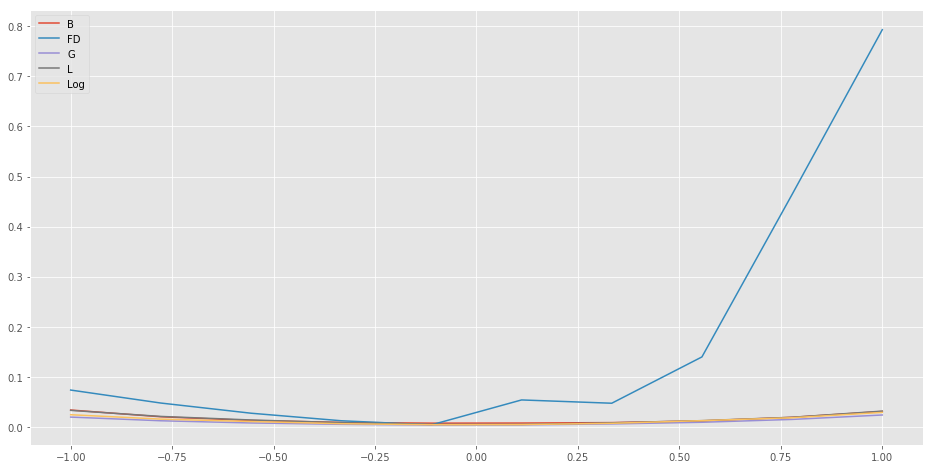

In [189]:
plt.plot(jnp.linspace(x_lower_bound, x_upper_bound, x_samples), B_res[:, 1], label="B")
plt.plot(jnp.linspace(x_lower_bound, x_upper_bound, x_samples), FD_res[:, 1], label="FD")
plt.plot(jnp.linspace(x_lower_bound, x_upper_bound, x_samples), G_res[:, 1], label="G")
plt.plot(jnp.linspace(x_lower_bound, x_upper_bound, x_samples), L_res[:, 1], label="L")
plt.plot(jnp.linspace(x_lower_bound, x_upper_bound, x_samples), Log_res[:, 1], label="Log")


# plt.yscale("log")
plt.legend()
plt.show()